### Data preparation

In [1]:
import numpy as np
import xarray as xr
import hdc.algo
import rioxarray

from read_data import get_mean_std_data
from sklearn.model_selection import train_test_split
#from hip.analysis.aoi.analysis_area import AnalysisArea

2024-04-16 08:30:10.762863: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-16 08:30:10.764960: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-16 08:30:10.812152: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-16 08:30:10.812894: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 08:30:11.754512: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Define area 

In [2]:
BBOX = (28.125,-29.875,41.875,-10.125)

**CHIRPS** 

In [26]:
# Define AnalysisArea
area = AnalysisArea(bbox=BBOX, datetime_range='1981-01-01/2023-12-31')

# Read data and clip to Moz
rfh = area.get_dataset(["CHIRPS","rfh_dekad"])

# Transpose dimensions
rfh = rfh.transpose('latitude', 'longitude', 'time')

# Select 28x28 zone
rfh = rfh.isel(latitude=slice(40, 68), longitude=slice(152, 180))

**Forecasts**

In [19]:
# Define AnalysisArea
area = AnalysisArea(bbox=BBOX, resolution=1, datetime_range='1981-01-01/2023-12-31')

# Read issue month forecasts
def read_one_issue_month_forecasts(issue: int):
    da = area.get_dataset(["ECMWF",f"RFH_FORECASTS_SEAS5_ISSUE{issue}_DAILY"]).sel(ensemble=0)
    da = da.where(da.time.dt.month == issue, drop=True)
    return da

da_all_months = xr.concat([read_one_issue_month_forecasts(i) for i in range(1, 13)], dim='time') 

In [28]:
# Select zone
fc = da_all_months.interp(latitude=rfh.latitude, longitude=rfh.longitude, method='nearest')

# Sum by dekad
fc = fc.groupby(fc.time.dekad.start_date).sum()

# Transpose dimensions
fc = fc.transpose('latitude', 'longitude', 'time')

# Drop spatial_ref
fc = fc.drop_vars('spatial_ref')

Harmonize CHIRPS dates

In [29]:
fc = fc.sel(time=rfh.time)

**Combine into a single dataset** 

In [30]:
ds = xr.Dataset({'chirps': rfh, 'ecmwf': fc})

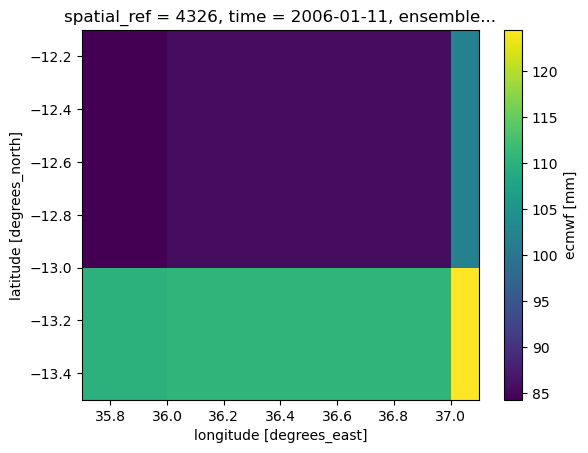

In [31]:
ds.isel(time=901).ecmwf.plot.imshow()

**Filter wet season** 

In [32]:
START_SEASON = 11
END_SEASON = 4

In [33]:
ds = ds.where(ds.time.dt.month.isin((np.arange(START_SEASON-1, END_SEASON+12)%12)+1), drop=True)

**Split train / test sets**

In [34]:
# Split train and test
train_dates, test_dates = train_test_split(ds.time, test_size=0.186, shuffle=False, random_state=888)

ds_train = ds.sel(time=train_dates)
ds_test = ds.sel(time=test_dates)

In [35]:
ds_test

<xarray.Dataset> Size: 1MB
Dimensions:      (latitude: 28, longitude: 28, time: 144)
Coordinates:
  * latitude     (latitude) float64 224B -12.13 -12.18 -12.23 ... -13.43 -13.48
  * longitude    (longitude) float64 224B 35.73 35.77 35.83 ... 37.02 37.08
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 1kB 2016-01-01 2016-01-11 ... 2023-12-21
    ensemble     int64 8B 0
Data variables:
    chirps       (latitude, longitude, time) float64 903kB dask.array<chunksize=(28, 28, 1), meta=np.ndarray>
    ecmwf        (latitude, longitude, time) float32 452kB dask.array<chunksize=(28, 28, 1), meta=np.ndarray>

In [36]:
# Save train data
_ = [ds_train.isel(time=slice(t,t+1)).to_zarr(f"data/train/smallarea28moztime{t}.zarr") for t in range(ds_train.time.size)]

In [37]:
# Save test data
_ = [ds_test.isel(time=slice(t,t+1)).to_zarr(f"data/test/smallarea28moztime{t}.zarr") for t in range(ds_test.time.size)]

**Normalize both datasets**

In [11]:
ecmwf_train

<xarray.DataArray 'ecmwf' (latitude: 28, longitude: 28, time: 735)> Size: 2MB
array([[[110.49652   ,  86.28845   ,  99.45679   , ...,  78.19748   ,
          85.02197   ,   3.7841797 ],
        [110.49652   ,  86.28845   ,  99.45679   , ...,  78.19748   ,
          85.02197   ,   3.7841797 ],
        [110.49652   ,  86.28845   ,  99.45679   , ...,  78.19748   ,
          85.02197   ,   3.7841797 ],
        ...,
        [ 66.57791   ,  95.321655  , 152.67944   , ..., 118.09921   ,
          96.85516   ,   8.743286  ],
        [ 66.57791   ,  95.321655  , 152.67944   , ..., 118.09921   ,
          96.85516   ,   8.743286  ],
        [ 66.57791   ,  95.321655  , 152.67944   , ..., 118.09921   ,
          96.85516   ,   8.743286  ]],

       [[110.49652   ,  86.28845   ,  99.45679   , ...,  78.19748   ,
          85.02197   ,   3.7841797 ],
        [110.49652   ,  86.28845   ,  99.45679   , ...,  78.19748   ,
          85.02197   ,   3.7841797 ],
        [110.49652   ,  86.28845   ,  99.45679   , ...,  78.19748   ,
          85.02197   ,   3.7841797 ],
...
        [ 34.908295  ,  55.57251   ,  56.289673  , ...,  67.88635   ,
          71.19751   ,   1.2664795 ],
        [ 34.908295  ,  55.57251   ,  56.289673  , ...,  67.88635   ,
          71.19751   ,   1.2664795 ],
        [ 34.908295  ,  55.57251   ,  56.289673  , ...,  67.88635   ,
          71.19751   ,   1.2664795 ]],

       [[ 44.91806   ,  72.92175   ,  32.836914  , ...,  54.782867  ,
          73.410034  ,   0.74768066],
        [ 44.91806   ,  72.92175   ,  32.836914  , ...,  54.782867  ,
          73.410034  ,   0.74768066],
        [ 44.91806   ,  72.92175   ,  32.836914  , ...,  54.782867  ,
          73.410034  ,   0.74768066],
        ...,
        [ 34.908295  ,  55.57251   ,  56.289673  , ...,  67.88635   ,
          71.19751   ,   1.2664795 ],
        [ 34.908295  ,  55.57251   ,  56.289673  , ...,  67.88635   ,
          71.19751   ,   1.2664795 ],
        [ 34.908295  ,  55.57251   ,  56.289673  , ...,  67.88635   ,
          71.19751   ,   1.2664795 ]]], dtype=float32)
Coordinates:
    ensemble     int64 8B 0
  * latitude     (latitude) float64 224B -15.13 -15.18 -15.23 ... -16.43 -16.48
  * longitude    (longitude) float64 224B 33.12 33.17 33.23 ... 34.42 34.48
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 6kB 1981-01-01 1981-01-11 ... 2015-12-21
Attributes:
    units:    mm

In [3]:
ecmwf_train = xr.open_mfdataset('data/train/*.zarr').ecmwf.load()
chirps_train = xr.open_mfdataset('data/train/*.zarr').chirps.load()

ecmwf_test = xr.open_mfdataset('data/test/*.zarr').ecmwf.load()
chirps_test = xr.open_mfdataset('data/test/*.zarr').chirps.load()

ecmwf = xr.concat([ecmwf_train, ecmwf_test], dim='time')
chirps = xr.concat([chirps_train, chirps_test], dim='time')

/envs/user/swirl/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/envs/user/swirl/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/envs/user/swirl/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/envs/user/swirl/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/envs/user/swirl/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/envs/user/swirl/lib/python3.11/site-pa

In [4]:
mean_chirps, var_chirps, mean_ecmwf, var_ecmwf = get_mean_std_data()

In [5]:
# Normalize
ecmwf = (ecmwf - mean_ecmwf) / (var_ecmwf + 1e-4)
chirps = (chirps - mean_chirps) / (var_chirps + 1e-4)

In [6]:
# Split again
ds = xr.Dataset({'chirps': chirps, 'ecmwf': ecmwf})

ds_train = ds.sel(time=ecmwf_train.time)
ds_test = ds.sel(time=ecmwf_test.time)

In [14]:
# Save normalized train data
ds_train.to_zarr(f"data/train_std.zarr", mode='w')
#_ = [ds_train.isel(time=slice(t,t+1)).to_zarr(f"data/train_std/smallarea28moztime{t}.zarr") for t in range(ds_train.time.size)]

In [15]:
# Save normalized test data
ds_test.to_zarr(f"data/test_std.zarr", mode='w')
#_ = [ds_test.isel(time=slice(t,t+1)).to_zarr(f"data/test_std/smallarea28moztime{t}.zarr", mode='w') for t in range(ds_test.time.size)]